## Importing required packages

In [33]:
import pandas as pd
import requests
import numpy as np
import os
from dotenv import load_dotenv
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

## Load Environment Variables

In [34]:
load_dotenv()
api_key = os.getenv('API_KEY')

# ScriptData class to fetch data from financial api for given script 

## store them in pandas dataframe

In [35]:
class ScriptData:
    def __init__(self):
        # dictionary for storing various intraday data scripts
        self.intraday_data = {}
        
    def fetch_intraday_data(self, script):
        # TimeSeries object with API key and output format as pandas dataframes
        ts = TimeSeries(key=api_key, output_format="pandas")
        # Get intraday data for the given script with interval of 5 minutes
        data, meta_data = ts.get_intraday(symbol=script, interval="5min")
        # Store the data in the intraday_data dictionary
        self.intraday_data[script] = data
        
    def convert_intraday_data(self, script):
        # Get the intraday data for the given script from the dictionary
        data = self.intraday_data[script]
        # Reset the index of the data and rename the columns to standard names
        data.reset_index(inplace=True)
        data.columns = ["timestamp", "open", "high", "low", "close", "volume"]
        self.intraday_data[script] = data
        
    def __getitem__(self, script):
        # indexing of ScriptData object with given script name.
        return self.intraday_data[script]
    
    def __setitem__(self, script, data):
        # Asetting the intraday data for a script by indexing the ScriptData object with the script name
        self.intraday_data[script] = data
        
    def __contains__(self, script):
        # Allow checking if a script's intraday data is already present in the ScriptData object using the 'in' operator
        return script in self.intraday_data


## Indicator1 function
### It should take “df” and ‘timeperiod’ (integer) as inputs and give another pandas DataFrame as an output with two columns:

        a. timestamp: Same as ‘timestamp’ column in ‘df’
        b. indicator: Moving Average of the ‘close’ column in ‘df’. The number of
        elements to be taken for a moving average is defined by ‘timeperiod’. For
        example, if ‘timeperiod’ is 5, then each row in this column will be an average
        of total 5 previous values (including current value) of the ‘close’ column.


In [36]:
def indicator1(df, timeperiod):
    # sliding average of 'close' column using rolling function
    ma = df["close"].rolling(timeperiod).mean()
    
    # new DataFrame with timestamp and indicator values
    result = pd.DataFrame({
        "timestamp": df["timestamp"],
        "indicator": ma
    })
    
    return result


## Class Strategy
     a. Fetch intraday historical day (‘df’) using ScriptData class.
        We’ll refer to the ‘close’ column of ‘df’ as close_data.
     b. Compute indicator data on ‘close’ of ‘df’ using indicator1 function.
        We’ll refer to the ‘indicator’ column of this data as indicator_data.
     c. Generate a pandas DataFrame called ‘signals’ with 2 columns:
        i. ‘timestamp’: Same as ‘timestamp’ column in ‘df’
        ii. ‘signal’: This column can have the following values:
        
        1. BUY (When: If indicator_data cuts close_data upwards)
        2. SELL (When: If indicator_data cuts close_data downwards)
        3. NO_SIGNAL (When: If indicator_data and close_data don’t cut each other)

In [37]:
class Strategy:
    def __init__(self, script):
        self.script_data = ScriptData()  # create an instance of the ScriptData class
        self.script = script
        
    def get_script_data(self):
        self.script_data.fetch_intraday_data(self.script)  # fetch intraday data for the script
        self.script_data.convert_intraday_data(self.script)  # convert the data to a DataFrame
        df = self.script_data[script]  # get the DataFrame for the script from the ScriptData object
        return df

    
    def get_signals(self):
        # Fetch intraday data and convert to a DataFrame
        self.script_data.fetch_intraday_data(self.script)
        self.script_data.convert_intraday_data(self.script)
        df = self.script_data[self.script]

        # Compute indicator data using the indicator1 function
        indicator_data = indicator1(df, timeperiod=5)["indicator"]
        
        # Generate signals based on the indicator and close data
        signals = pd.DataFrame({
            "timestamp": df["timestamp"],
            "signal": "NO_SIGNAL"
        })
        
        signals.loc[indicator_data > df["close"], "signal"] = "BUY"
        signals.loc[indicator_data < df["close"], "signal"] = "SELL"
        
        return signals.loc[signals["signal"].isin(["BUY", "SELL"])]


### Instance of ScriptData() class

In [ ]:
script_data = ScriptData()
script_data.fetch_intraday_data('AAPL')

In [39]:
script_data.convert_intraday_data('AAPL')
script_data['AAPL'].head()

,timestamp,open,high,low,close,volume
0,2023-02-13 20:00:00,153.66,153.70,153.60,153.70,7841.0
1,2023-02-13 19:55:00,153.64,153.67,153.64,153.66,4691.0
2,2023-02-13 19:50:00,153.65,153.65,153.61,153.63,3566.0
3,2023-02-13 19:45:00,153.65,153.67,153.65,153.67,2083.0
4,2023-02-13 19:40:00,153.65,153.66,153.65,153.66,6946.0


In [44]:
# create an indicator dataframe using indicator1 function with timeperiod 5
indicator = indicator1(script_data['AAPL'],timeperiod=5)
indicator

,timestamp,indicator
0,2023-02-13 20:00:00,NaN
1,2023-02-13 19:55:00,NaN
2,2023-02-13 19:50:00,NaN
3,2023-02-13 19:45:00,NaN
4,2023-02-13 19:40:00,153.66400
...,...,...
95,2023-02-13 12:05:00,153.83488
96,2023-02-13 12:00:00,153.68798
97,2023-02-13 11:55:00,153.60598
98,2023-02-13 11:50:00,153.56898


In [41]:
# create an object strategy an instance of Strategy class with 'AAPL' as script
strategy = Strategy('AAPL')
signals = strategy.get_signals()
signals.head()

,timestamp,signal
4,2023-02-13 19:40:00,BUY
5,2023-02-13 19:35:00,BUY
6,2023-02-13 19:30:00,BUY
7,2023-02-13 19:25:00,BUY
8,2023-02-13 19:20:00,BUY


No handles with labels found to put in legend.


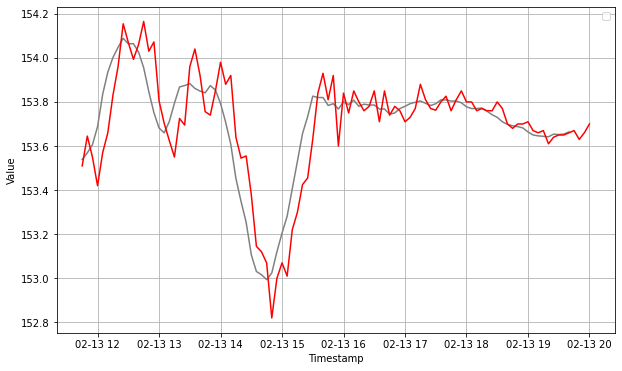

In [42]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot indicator_data
ax.plot(script_data['AAPL']['timestamp'], indicator['indicator'], color='grey')

# Plot close_data
ax.plot(script_data['AAPL']['timestamp'], script_data['AAPL']['close'], color='red')

# Add legend and axis labels
ax.legend()
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')

#adding grids
plt.grid()

# Show the plot
plt.show()


In [45]:
'AAPL' in script_data

True

In [46]:
'GOOGL' in script_data

False